In [17]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
import pandas as pd

In [2]:
from rsnn.signals.spike_train import SpikeTrain, PeriodicSpikeTrain

In [63]:
duration = 100
soft_refractory_period = 10
hard_refractory_period = 5
firing_rate = 0.1
num_channels = 500

rmax = 5
rtol = 1e-3
res = 1e-2

In [64]:
spike_train = SpikeTrain(num_channels, duration, firing_rate, hard_refractory_period, soft_refractory_period)

In [65]:
spike_train.random()

In [66]:
periodic_spike_train = PeriodicSpikeTrain(num_channels, duration, firing_rate, hard_refractory_period, soft_refractory_period)

In [67]:
periodic_spike_train.random()

In [68]:
x = np.concatenate(
    [np.append(ft[1:] - ft[:-1], ft[0] + duration - ft[-1]) for ft in periodic_spike_train.firing_times]
)
df = pd.DataFrame({"x":x})

In [69]:
if soft_refractory_period > 0:
    hazard = lambda t_ : (t_ >= hard_refractory_period) * firing_rate * (1 - np.exp(-(t_ - hard_refractory_period) / soft_refractory_period )) # hazard function = conditional firing rate
    Hazard = lambda t_ : (t_ >= hard_refractory_period) * firing_rate * soft_refractory_period * ((t_ - hard_refractory_period) / soft_refractory_period + np.exp(-(t_ - hard_refractory_period) / soft_refractory_period) - 1)
else:
    hazard = lambda t_ : (t_ >= hard_refractory_period) * firing_rate
    Hazard = lambda t_ : (t_ >= hard_refractory_period) * firing_rate * t_

q = lambda t_ : hazard(t_) * np.exp(-Hazard(t_)) # pdf
# survival = lambda t_ : np.exp(- Hazard(t_)) # survival
Q = lambda t_ : 1 - np.exp(- Hazard(t_)) # probability of a spike

In [70]:
t = np.linspace(0, duration, 1000)
qt = q(t)

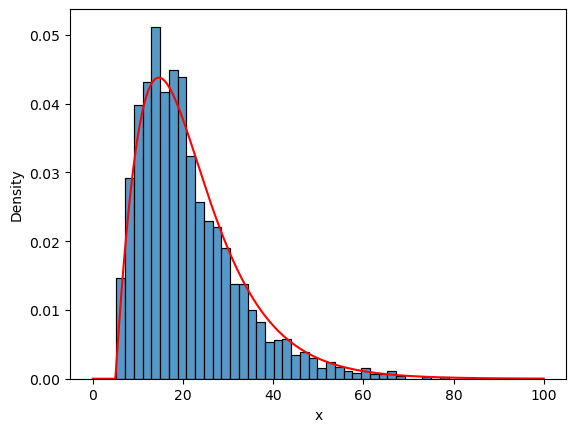

In [71]:
sns.histplot(df, x="x", stat="density")
plt.plot(t, qt, "red")

In [175]:
rng.uniform()

0.8665777481229582

In [22]:
rng = np.random.default_rng()

In [27]:

def norm(x):
    return x / np.sum(x)

In [45]:
period = 100
soft_refractory_period = 5
hard_refractory_period = 5
firing_rate = 0.1
num_channels = 100

rmax = 5
rtol = 1e-4
res = 1e-2

In [46]:
if soft_refractory_period > 0:
    hazard = lambda t_ : (t_ >= hard_refractory_period) * firing_rate * (1 - np.exp(-(t_ - hard_refractory_period) / soft_refractory_period )) # hazard function = conditional firing rate
    Hazard = lambda t_ : (t_ >= hard_refractory_period) * firing_rate * soft_refractory_period * ((t_ - hard_refractory_period) / soft_refractory_period + np.exp(-(t_ - hard_refractory_period) / soft_refractory_period) - 1)
else:
    hazard = lambda t_ : (t_ >= hard_refractory_period) * firing_rate
    Hazard = lambda t_ : (t_ >= hard_refractory_period) * firing_rate * t_

q = lambda t_ : hazard(t_) * np.exp(-Hazard(t_)) # pdf
# survival = lambda t_ : np.exp(- Hazard(t_)) # survival
Q = lambda t_ : 1 - np.exp(- Hazard(t_)) # probability of a spike

# implicit zero padding with rmax
t = (np.arange(0, period, res)[None,:] + period * np.arange(rmax)[:,None]).flatten()
idx = np.ceil(period/res).astype(int) # when the period ends
qt = norm(q(t))

In [47]:
# 1. compute forward messages 
# convolution in the time domain = multiplication in the frequency domain
qf = np.fft.rfft(qt)
tmp = np.copy(qf)
msgf = [qt]
while np.argmax(msgf[-1]) < idx or msgf[-1][idx] > rtol * np.max(msgf[-1]):
    tmp = tmp * qf
    msgf.append(norm(np.around(np.fft.irfft(tmp), 9)))
msgf = np.stack(msgf, axis=0)

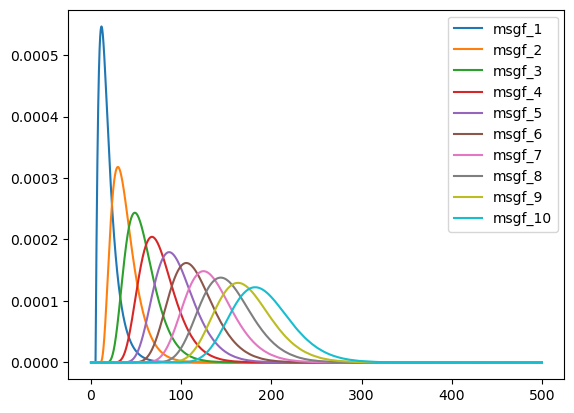

In [48]:
legends = []
for n in range(10):
    plt.plot(t, msgf[n])
    legends.append(f"msgf_{n+1}")
plt.legend(legends)
plt.show()

In [49]:
# 2. compute distribution of number of firings
pn = norm(msgf[:, idx])

In [54]:
firing_times = []
# 3. sample per channels
for c in range(num_channels):
    # 3.a. is there any spike?
    if rng.binomial(1, Q(period)) == 0:
        firing_times.append(np.array([]))
        continue
        
    # 3.b. given there is at least one spike, sample the exact number of spikes in the sequence
    n = rng.choice(len(pn), p=pn) + 1
    
    # 3.c. given the exact number of spikes, sample sn, ..., s1 by backward sampling, starting from sn = period
    s = np.empty(n)
    s[-1] = period
    for m in range(n-2, -1, -1):
        psm = norm(msgf[m] * q(s[m+1] - t))
        s[m] = rng.choice(t, p=psm)
        
    # 3.d random cyclic shift
    s0 = rng.uniform(0, period)
    s += s0
    firing_times.append(np.sort(s % period))

In [55]:
firing_times

[array([36.61757206, 44.98757206, 68.60757206, 75.41757206, 91.27757206,
        97.39757206]),
 array([14.10036428, 24.36036428, 31.90036428, 47.46036428, 82.54036428]),
 array([ 1.90848352, 15.23848352, 25.77848352, 34.95848352, 46.72848352,
        64.70848352, 83.59848352, 92.78848352]),
 array([ 4.63350931, 31.37350931, 47.78350931, 53.83350931, 62.58350931,
        70.88350931, 81.05350931, 87.19350931]),
 array([48.60843482, 85.57843482]),
 array([ 9.87664759, 23.95664759, 38.08664759, 50.30664759, 70.36664759,
        81.18664759, 90.31664759]),
 array([14.30484739, 29.80484739, 40.61484739, 94.04484739]),
 array([ 7.86722538, 29.99722538, 48.38722538, 61.18722538, 96.41722538]),
 array([ 3.76057768, 17.21057768, 46.22057768, 60.51057768, 81.62057768,
        92.50057768]),
 array([ 8.9444531, 22.3644531, 34.7444531, 49.4244531, 59.6444531,
        68.0744531, 78.1644531]),
 array([19.99398689, 26.92398689, 62.63398689, 74.58398689, 85.43398689]),
 array([16.52095387, 32.250953

In [46]:
np.sum(msgf[1]), np.sum(q(1-t))

(1.0000000000000002, 0.0)

In [124]:
msgf[0, idx]

array([[1.23409803e-08]])

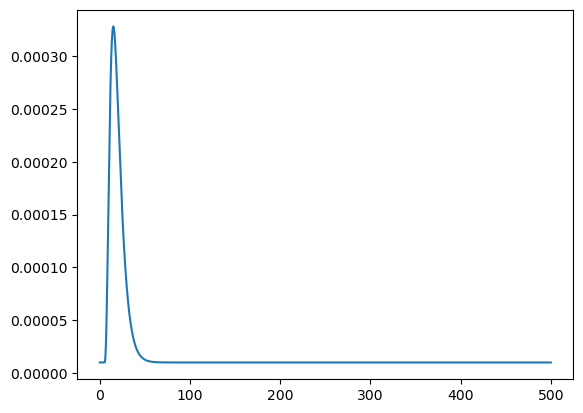

In [53]:
plt.plot(t, msgf[1])
plt.show()

In [87]:
np.min(msgf[4])

0.0527910300782802

In [19]:
t = np.arange(0, 2*period, 0.1)
t[t == period]

4.49 µs ± 36.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [27]:
qt = q(t)
qf = scipy.fft.fft(qt, 2*len(t)-1)

In [29]:
%timeit np.power(qf, 5)

36.3 µs ± 112 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [30]:
qqqqf = np.power(qf, 4)

In [31]:
%timeit qqqqf * qf

4.43 µs ± 18.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [5]:
%matplotlib notebook

In [6]:
plt.style.use('scientific')
torch.manual_seed(42);

In [7]:
T, Tr = 100, 20

# Spiking Matrix

In [8]:
from rsnn.ss.utils import get_spiking_matrix, get_phi0

<IPython.core.display.Javascript object>


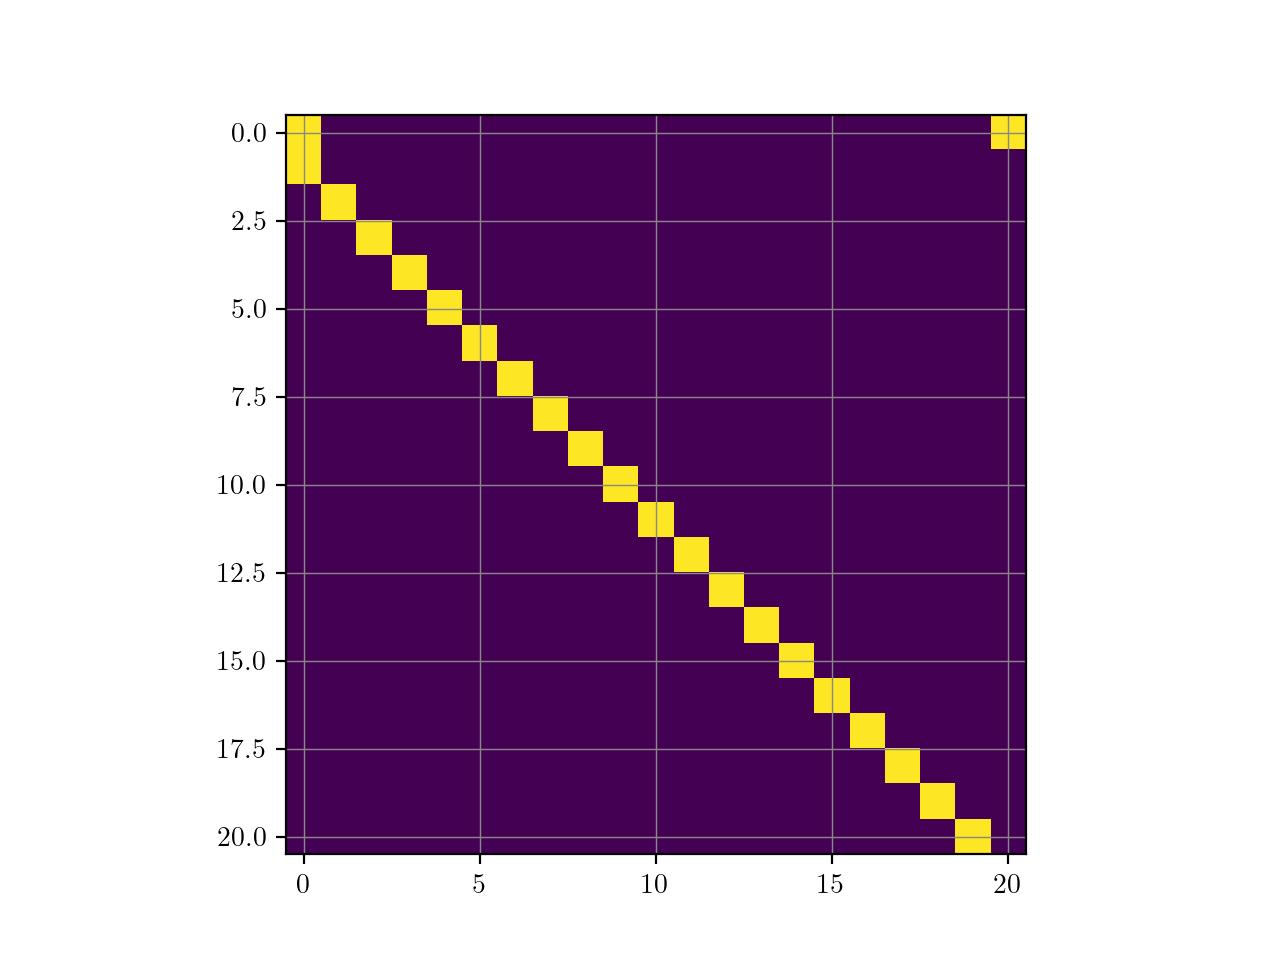

In [9]:
plt.figure()
plt.imshow(get_spiking_matrix(Tr))
plt.show()

In [10]:
f"The spectral radius for Tr={Tr} is phi0={get_phi0(Tr)}"

'The spectral radius for Tr=20 is phi0=1.1144648799534793'

# Counting

In [11]:
from rsnn.ss.utils import get_cardinality

In [12]:
f"There are {get_cardinality(T, Tr, approx=False)} spike sequences with length {T} and refractory period {Tr}"

'There are 51976.0 spike sequences with length 100 and refractory period 20'

In [13]:
f"There are around {get_cardinality(T, Tr, approx=True)} spike sequences with length {T} and refractory period {Tr}"

'There are around 50890.7339457872 spike sequences with length 100 and refractory period 20'

# Sampling

In [15]:
from rsnn.ss.rand import rand_ss

In [30]:
ss = rand_ss(1, 100000, 10, 0.5)
ss.sum() / (100000 - ss.sum() * 10) 

tensor(0.4949)

In [27]:
ss = rand_ss(1, 10000, 10, 0.8)
ss.sum() / (10000 - ss.sum() * 10)

tensor(0.8009)

In [28]:
ss = rand_ss(1, 10000, 10, 0.2)
ss.sum() / (10000 - ss.sum() * 10)

tensor(0.1976)

In [19]:
s_ids = torch.argwhere(rand_ss(1, T, Tr, 0.95))[:, 1].numpy()

<IPython.core.display.Javascript object>


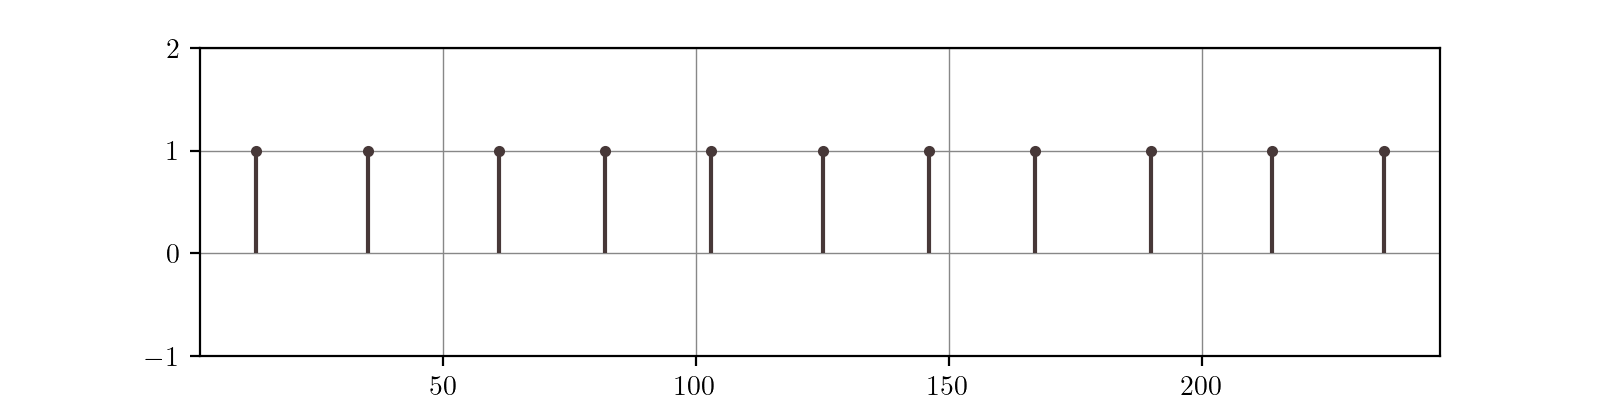

In [20]:
plt.figure(figsize=(8, 2))
plt.stem(s_ids, np.ones_like(s_ids), basefmt=" ", linefmt="C0-", markerfmt="C0.")
plt.ylim(-1, 2)
plt.show()

# Marginal and Empirical Number of Spikes

In [21]:
spike_sequences = sample_spike_sequences(200, 10, 1000)

In [22]:
spike_sequences.float().mean(), 1/(get_phi0(10)**(11) + 10)

(tensor(0.0608), 0.060876747580960344)

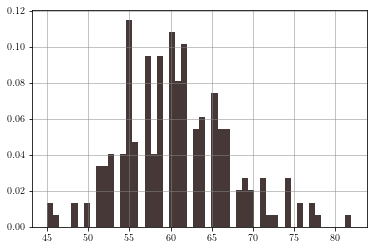

In [27]:
_ = plt.hist(spike_sequences.float().sum(dim=1).numpy(), bins=50, density=True)

In [23]:
A = torch.tensor([[1, 0, 1], [0, 0, 1], [0, 0, 1]])
A.matrix_power(10)

tensor([[ 1,  0, 10],
        [ 0,  0,  1],
        [ 0,  0,  1]])